Final Project 
======

Kaggle Competition 
-----

For this project I chose to do the active competition [San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime/). I'll test out a number of different algorithms with test data. I am interested in this type of analysis as it is data science that contributes to the common good.

#### Import libraries

In [1]:
# Pandas and numpy
import pandas as pd
import numpy as np

# Python functions
from dateutil.relativedelta import *
from datetime import datetime

# Patsy 
from patsy import dmatrices

# sklearn functions
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest,\
                        SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots BIG
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 8

# GIS functionality
from mpl_toolkits.basemap import Basemap, cm
import cartopy.io.shapereader as shpreader
import fiona
import pysal 
from pyproj import Proj
from pysal.cg.shapes import Point
from pysal.cg.locators import PolygonLocator, PointLocator, BruteForcePointLocator 
from pysal.cg.sphere import arcdist

# Multiprocessing 
import multiprocessing

In [2]:
class MultiColumnLabelEncoder:
    ''' Create a class that encodes
        labels for a matrix of data
    '''
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here
    
    def get_params(self, deep=True):
        out = dict()
        if self.columns: out['columns'] = columns
        return out

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). 
        '''
        numerics = [np.float16, np.float32, np.float64]
        ints = [np.int16, np.int32, np.int64]
        output = X.copy()
        '''
        if self.columns is not None:
            for col in self.columns:
                if col.dtype not in numerics+ints:
                    output[col] = LabelEncoder().fit_transform(output[col])
                elif col.dtype not in ints:
                    output[col] = scale(output[col])
        else:
        '''
        try:
            for colname,col in output.iteritems():
                if col.dtype not in numerics+ints:
                    output[colname] = LabelEncoder().fit_transform(output[colname])
                elif col.dtype not in ints:
                    output[colname] = scale(output[colname])
        except:
            output = LabelEncoder().fit_transform(output)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

#### Part 1 - Submit first (bad) try

In [122]:
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


In [123]:
train_raw.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [124]:
test_raw.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [125]:
sample_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [126]:
train_data\
,train_labels = train_raw[['DayOfWeek'\
                                     ,'PdDistrict'\
                                     ,'Address'\
                                     ,'X'\
                                     ,'Y']][2001:]\
                            ,train_raw['Category'][2001:]
dev_data\
,dev_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][:1000]\
                            ,train_raw['Category'][:1000]
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
test_data = test_raw[['DayOfWeek'\
                     ,'PdDistrict'\
                     ,'Address'\
                     ,'X'\
                     ,'Y']]

In [127]:
rf = RandomForestClassifier() #leaving with default settings for now

Data needs to be preprocessed for RF in sklearn

In [128]:
def recode(df):
    numerics = ['float16', 'float32', 'float64']
    ints = ['int16', 'int32', 'int64']
    for i in range(df.shape[1]):
        t = df.iloc[:,i].dtype
        if t not in numerics or ints:
            le = LabelEncoder()
            le.fit(df.iloc[:,i])
            df.iloc[:,i] = le.transform(df.iloc[:,i])
        elif t not in ints:
            df.iloc[:,i] = scale(df.iloc[:,i])
    return df

def recode_labels(df):
    le = LabelEncoder()
    le.fit(df)
    return le

In [129]:
dev_data = recode(dev_data)
dev_label_le = recode_labels(np.concatenate((dev_labels,dev_test_labels),axis=1))
dev_labels = dev_label_le.transform(dev_labels)
dev_test_data = recode(dev_test_data)
dev_test_labels = dev_label_le.transform(dev_test_labels)

Run model

In [130]:
rf.fit(dev_data,dev_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [131]:
predictions = rf.predict(dev_test_data)

In [132]:
actual_predictions = dev_label_le.inverse_transform(predictions)
actual_labels = dev_label_le.inverse_transform(dev_test_labels)
print actual_predictions[:5],'\n',actual_labels[:5]

['BURGLARY' 'LARCENY/THEFT' 'LARCENY/THEFT' 'NON-CRIMINAL' 'NON-CRIMINAL'] 
['OTHER OFFENSES' 'LARCENY/THEFT' 'LARCENY/THEFT' 'WARRANTS' 'WARRANTS']


In [133]:
accuracy = np.sum((actual_predictions == actual_labels)*1.0)/len(dev_labels)
print 'Dev Accuracy: {0}%'.format(accuracy*100)

Dev Accuracy: 20.9%


Train with real data

In [134]:
train_data, test_data = recode(train_data), recode(test_data)
train_le = recode_labels(train_labels)
train_labels = train_le.transform(train_labels)

In [135]:
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Make predictions and reformat for submission

In [136]:
predictions = rf.predict(test_data)
actual_predictions = train_le.inverse_transform(predictions)

In [137]:
l = len(test_data)
submission = np.zeros((l,40),dtype=np.int32)
submission[:,0] = range(l)
cols = train_le.classes_ 
for i,c in enumerate(cols):
    submission[:,i+1] = actual_predictions == c

In [138]:
submission_cols = ['Id']
submission_cols.extend(cols)
submission_df = pd.DataFrame(submission,columns=submission_cols)
submission_df.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Save data to csv file for submission

In [139]:
# submission_df.to_csv('Data/submission_file1.csv',index=False)

First attempt: Rank 208, score 26.95890, tested accuracy of ~20-23%.

##### See where model breaks down

In [140]:
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
dev_test_data = recode(dev_test_data)
predictions = rf.predict(dev_test_data)
actual_predictions = train_le.inverse_transform(predictions)

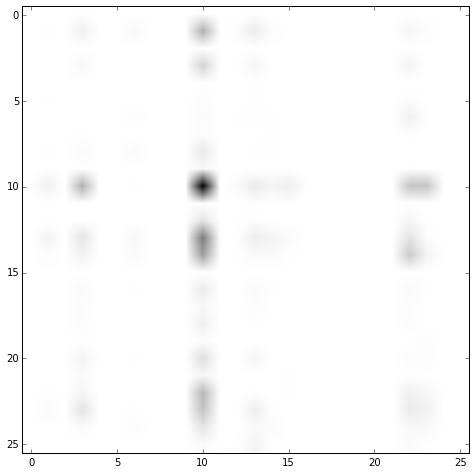

In [141]:
conf = confusion_matrix(dev_test_labels,actual_predictions)
plt.imshow(conf, cmap='binary')

In [142]:
pd.crosstab(dev_test_labels, actual_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,RECOVERED VEHICLE,ROBBERY,VANDALISM,VEHICLE THEFT,All
True,,,,,,,,,,,,
ARSON,0,1,0,1,0,1,0,0,0,1,0,4
ASSAULT,1,9,4,43,2,11,2,0,0,5,2,79
BRIBERY,0,0,0,1,0,0,0,0,0,0,0,1
BURGLARY,0,4,0,23,1,5,0,0,0,6,0,39
DISORDERLY CONDUCT,0,0,0,1,0,1,0,0,0,0,0,2
DRIVING UNDER THE INFLUENCE,1,0,0,2,0,1,0,0,0,2,0,6
DRUG/NARCOTIC,0,0,2,3,1,1,1,0,0,8,1,17
DRUNKENNESS,0,1,0,2,0,0,1,0,0,1,0,5
FRAUD,1,3,3,12,0,1,1,0,0,0,0,21


Since samples are not weighted well in terms of categories, the model seems to be having difficulties with categories that have a larger amount of observations - likely because all of the conditions used to predict crimes are seen more frequently for the samples with more observations. To make the model generalize better, it will be necessary to resample the dataset so that possible outcomes are represented more evenly. 

#### Part 2 - Tests to increase accuracy

In [3]:
# Reload data - start from here 
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


##### Gather together cases that seem to be at same time/location or otherwise related
This did not have a positive effect on model - will probably remove

In [144]:
def gather_crimes(df):
    ''' Some crimes seem to be linked
        to each other 
        Group crimes in the same address
        within an hour of each other
    '''
    n = df.shape[0]
    out = np.zeros(n,dtype=np.int64)
    d_last = datetime(1970,1,1)
    addr_last = 'Unknown'
    x = 0
    for i in range(n):
        if i%100000==0: print 'Working row {0}'.format(i)
        d = df.iloc[i]['Dates']
        if d < d_last: raise Exception('Dates not sorted')
        addr = df.iloc[i]['Address']
        r = d+relativedelta(hours=-1)
        if r > d_last or addr_last!=addr: x+=1
        d_last = d
        addr_last = addr
        out[i] = x
    return out

def run_crimegrouping():
    train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
    test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])
    train_raw = train_raw.sort(['Dates'],kind='mergesort')
    test_raw = test_raw.sort(['Dates'],kind='mergesort')
    train_raw['crime_groupid'] = gather_crimes(train_raw)
    test_raw['crime_groupid'] = gather_crimes(test_raw)
    train_raw.to_csv('Data/train_raw_wcrimegroup.csv',index=False)
    test_raw.to_csv('Data/test_raw_wcrimegroup.csv',index=False)

In [145]:
print train_raw[['Category','Descript']].groupby(['Category']).agg(len)

                             Descript
Category                             
ARSON                            1513
ASSAULT                         76876
BAD CHECKS                        406
BRIBERY                           289
BURGLARY                        36755
DISORDERLY CONDUCT               4320
DRIVING UNDER THE INFLUENCE      2268
DRUG/NARCOTIC                   53971
DRUNKENNESS                      4280
EMBEZZLEMENT                     1166
EXTORTION                         256
FAMILY OFFENSES                   491
FORGERY/COUNTERFEITING          10609
FRAUD                           16679
GAMBLING                          146
KIDNAPPING                       2341
LARCENY/THEFT                  174900
LIQUOR LAWS                      1903
LOITERING                        1225
MISSING PERSON                  25989
NON-CRIMINAL                    92304
OTHER OFFENSES                 126182
PORNOGRAPHY/OBSCENE MAT            22
PROSTITUTION                     7484
RECOVERED VE

In [175]:
def show_descripts(cat):
    g = train_raw[train_raw['Category']==cat]\
        [['Category','Descript']]\
        .groupby(['Category','Descript']).agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: x[1], reverse=True):
        print x

show_descripts('DRUG/NARCOTIC')

(('DRUG/NARCOTIC', 'POSSESSION OF NARCOTICS PARAPHERNALIA'), 10050)
(('DRUG/NARCOTIC', 'POSSESSION OF BASE/ROCK COCAINE'), 7160)
(('DRUG/NARCOTIC', 'POSSESSION OF MARIJUANA'), 5395)
(('DRUG/NARCOTIC', 'SALE OF BASE/ROCK COCAINE'), 4307)
(('DRUG/NARCOTIC', 'POSSESSION OF METH-AMPHETAMINE'), 3702)
(('DRUG/NARCOTIC', 'POSSESSION OF BASE/ROCK COCAINE FOR SALE'), 3586)
(('DRUG/NARCOTIC', 'POSSESSION OF MARIJUANA FOR SALES'), 2746)
(('DRUG/NARCOTIC', 'POSSESSION OF CONTROLLED SUBSTANCE'), 2100)
(('DRUG/NARCOTIC', 'POSSESSION OF HEROIN'), 2003)
(('DRUG/NARCOTIC', 'POSSESSION OF COCAINE'), 1423)
(('DRUG/NARCOTIC', 'SALE OF MARIJUANA'), 1405)
(('DRUG/NARCOTIC', 'POSSESSION OF METH-AMPHETAMINE FOR SALE'), 1115)
(('DRUG/NARCOTIC', 'POSSESSION OF CONTROLLED SUBSTANCE FOR SALE'), 1034)
(('DRUG/NARCOTIC', 'POSSESSION OF HEROIN FOR SALES'), 882)
(('DRUG/NARCOTIC', 'SALE OF CONTROLLED SUBSTANCE'), 790)
(('DRUG/NARCOTIC', 'POSSESSION OF COCAINE FOR SALES'), 645)
(('DRUG/NARCOTIC', 'SALE OF HEROIN'), 59

In [176]:
def collar_crimes(x,y):
    ''' Add a meta category for 
        crimes based on the skills
        required
    '''
    blue_collar_violent = [ 
                   "ASSAULT"
                   , "KIDNAPPING"
                   , "ARSON"
                   , 'DOMESTIC VIOLENCE'
                   , 'GANG ACTIVITY'
                  ]
    blue_collar_other = [
                "VANDALISM"
                ,"DISORDERLY CONDUCT"
                ,"TRESPASS"
                ,'TREA'
               , 'LOITERING'
                ,'RESISTING ARREST'
                ,'PROBATION VIOLATION'
                ,'PROBATION VIOLATION'
                ,'VIOLATION OF RESTRAINING ORDER'
                ,'PAROLE VIOLATION'
    ]
    sex_crimes = [
            'SEX OFFENSES FORCIBLE',
            'PORNOGRAPHY/OBSCENE MAT',
            'SEX OFFENSES NON FORCIBLE',
            'PROSTITUTION'
        ]
    alcohol = [
        'DRIVING UNDER THE INFLUENCE',
        'DRUNKENNESS',
        'LIQUOR LAWS'
    ]
    drug = ['DRUG/NARCOTIC']
    theft = [
        'LARCENY/THEFT',
         'STOLEN PROPERTY',
         "ROBBERY",
         'CREDIT CARD, THEFT BY USE OF',
        'FRAUDULENT USE OF AUTOMATED TELLER CARD',
        'BURGLARY'
    ]
    vehicle = [
        'RECOVERED VEHICLE',
        'VEHICLE THEFT',
        'DRIVERS LICENSE, SUSPENDED OR REVOKED',
        'TRAFFIC VIOLATION',
        'TRAFFIC VIOLATION ARREST',
        'DRIVERS LICENSE, SUSPENDED OR REVOKED',
        'LOST/STOLEN LICENSE PLATE',
        'IMPOUNDED VEHICLE',
        'TRAFFIC ACCIDENT',
        'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES'
    ]
    noncrime = [
        'MISSING PERSON',
        'RUNAWAY',
        'SUICIDE',
        'NON-CRIMINAL',
        'SUSPICIOUS OCC'
    ]
    white_collar = [ 
        "FRAUD"
       , "FORGERY/COUNTERFEITING"
       , "BAD CHECKS" 
       , "EXTORTION"
       , "EMBEZZLEMENT"
       , "BRIBERY"
        , 'CONSPIRACY'
    ]
    if x in blue_collar_violent or y in blue_collar_violent: return 1
    elif x in sex_crimes or y in sex_crimes: return 2
    elif x in alcohol or y in alcohol: return 3
    elif x in drug or y in drug: return 4
    elif x in theft or y in theft: return 5
    elif x in vehicle or y in vehicle: return 6
    elif x in noncrime or y in noncrime: return 7
    elif x in white_collar or y in white_collar: return 8
    elif x in blue_collar_other or y in blue_collar_other: return 9
    else: return 10
collar_crimes = np.vectorize(collar_crimes,otypes=[np.int64])
train_raw['collar_id'] = collar_crimes(train_raw['Category'],train_raw['Descript'])

In [178]:
def show_descripts(col):
    g = train_raw[train_raw['collar_id']==col]\
        [['Category','Descript']]\
        .groupby(['Category','Descript']).agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: x[1], reverse=True):
        print x

show_descripts(10)

(('WARRANTS', 'WARRANT ARREST'), 23754)
(('WARRANTS', 'ENROUTE TO OUTSIDE JURISDICTION'), 11470)
(('OTHER OFFENSES', 'MISCELLANEOUS INVESTIGATION'), 8389)
(('WARRANTS', 'ENROUTE TO DEPARTMENT OF CORRECTIONS'), 3247)
(('OTHER OFFENSES', 'OBSCENE PHONE CALLS(S)'), 2492)
(('OTHER OFFENSES', 'FALSE PERSONATION TO RECEIVE MONEY OR PROPERTY'), 2339)
(('OTHER OFFENSES', 'VIOLATION OF MUNICIPAL CODE'), 2308)
(('OTHER OFFENSES', 'HARASSING PHONE CALLS'), 2194)
(('WARRANTS', 'ENROUTE TO PAROLE OFFICER'), 2149)
(('OTHER OFFENSES', 'POSSESSION OF BURGLARY TOOLS'), 2085)
(('WEAPON LAWS', 'POSS OF LOADED FIREARM'), 1963)
(('OTHER OFFENSES', 'VIOLATION OF MUNICIPAL POLICE CODE'), 1903)
(('OTHER OFFENSES', 'MISCELLANEOUS STATE MISDEMEANOR'), 1867)
(('OTHER OFFENSES', 'FALSE PERSONATION'), 1561)
(('OTHER OFFENSES', 'FALSE EVIDENCE OF VEHICLE REGISTRATION'), 1227)
(('WEAPON LAWS', 'CARRYING A CONCEALED WEAPON'), 1000)
(('OTHER OFFENSES', 'FRAUDULENT GAME OR TRICK, OBTAINING MONEY OR PROPERTY'), 939)
(('

Since we don't have crime category in the final set of data, test out prediction of metaclass within training set

In [148]:
def sample_df(df,group_name,groups,group_n):
    ''' Do sampling manually with 
        even group size 
        
        Keeps as many unique observations 
        as possible without replacement
    '''
    x = df.copy()
    out = []
    for g in groups:
        try:
            # Replace only when necessary
            out.append(x[x[group_name]==g].\
                   sample(group_n,replace=False))
        except:
            n = len(x[x[group_name]==g])
            out.append(x[x[group_name]==g])
            out.append(x[x[group_name]==g]\
                   .sample(group_n-n,replace=True))
    out_df = pd.concat(out)
    s = out_df.sample(group_n*len(groups)\
                      ,replace=True)
    return s

##### Add time of day 

In [149]:
def segment_time1(ts):
    ''' Segment time of day '''
    if ts.hour<=4: return 1
    elif ts.hour<=8: return 2
    elif ts.hour<=12: return 3
    elif ts.hour<=16: return 4
    elif ts.hour<=20: return 5
    elif ts.hour<=24: return 6
def segment_time2(ts):
    ''' Return only hour '''
    return ts.hour
def dayofmonth(ts):
    ''' Return day of month '''
    return ts.day
def yearofcrime(ts):
    ''' Return the year '''
    return ts.year

train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])

train_raw['DaySegment'] = train_raw['Dates'].apply(segment_time1)
test_raw['DaySegment'] = test_raw['Dates'].apply(segment_time1)

train_raw['TimeOfDay'] = train_raw['Dates'].apply(segment_time2)
test_raw['TimeOfDay'] = test_raw['Dates'].apply(segment_time2)

train_raw['DayOfMonth'] = train_raw['Dates'].apply(dayofmonth)
test_raw['DayOfMonth'] = test_raw['Dates'].apply(dayofmonth)

train_raw['Year'] = train_raw['Dates'].apply(yearofcrime)
test_raw['Year'] = test_raw['Dates'].apply(yearofcrime)

##### Add clustering based on lat/lon

Currently, by using the exact location of the crime, the model does not generalize very well. A couple options are available: 1) utilize publicly available datasets on city neighborhoods to classify each event into a more generalized city segment, perhaps based on income levels, 2) use a clustering algorithm like K-means to segment the training data into clusters where there are crime "hotspots" and add one of these as a feature (replacing lat/lon and potentially address - will test the removal of features separately). 

I will first attempt #2 while looking for good options for #1. 

In [150]:
def test_clusters(range_n_clusters,fields=['X','Y','TimeOfDay','Year']):
    km_models = []
    i_scores = []
    tr = train_raw[fields].copy()
    tr = le.fit_transform(tr)
    for n_clusters in range(range_n_clusters):
        if n_clusters>1:
            km = KMeans(n_clusters=n_clusters, random_state=5)
            km.fit(tr)
            km_models.append(km)
            inertia = km.inertia_ 
            print 'For {0}, inertia = {1}'.format(
                n_clusters, inertia
            )
            i_scores.append(inertia)
       
    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('KMeans inertia values')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Inertia')
    ax.plot([i for i in range(range_n_clusters) \
             if i>1],i_scores,'-', linewidth=2)
    plt.show()
    
#test_clusters(25)

In [151]:
# Reload data in case of changes
le = MultiColumnLabelEncoder()
tr = train_raw[['X','Y','TimeOfDay','Year']].copy()
tr = le.fit_transform(tr)

# Set k
k = 20

# Initialize Kmeans model
km = KMeans(n_clusters=k)
train_raw['KMcluster'] = km.fit_predict(tr)

# Calculate distances
distances = km.transform(tr)
train_raw['KMdistance'] = np.argmin(distances,axis=1)

# Predict for test dataset
tr = test_raw[['X','Y','TimeOfDay','Year']].copy()
tr = le.transform(tr)
test_raw['KMcluster'] = km.predict(tr)
distances = km.transform(tr)
test_raw['KMdistance'] = np.argmin(distances,axis=1)

In [152]:
g = train_raw.groupby('KMcluster')
g['KMcluster'].agg(len)

KMcluster
0     49124
1     37513
2     51397
3     54043
4     41016
5     43779
6     35089
7     50698
8        67
9     57126
10    43676
11    48678
12    32740
13    51040
14    61556
15    56984
16    53151
17    29080
18    45109
19    36183
Name: KMcluster, dtype: int32

In [212]:
def show_clustercat(cluster):
    g = train_raw[train_raw['KMcluster']==cluster].groupby(['Category','KMcluster'])['Category'].agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: (x[0][1],x[1]), reverse=True):
        print x
    
show_clustercat(11)

(('LARCENY/THEFT', 11), 11494)
(('OTHER OFFENSES', 11), 6986)
(('NON-CRIMINAL', 11), 4319)
(('ASSAULT', 11), 4045)
(('DRUG/NARCOTIC', 11), 3574)
(('VANDALISM', 11), 3175)
(('VEHICLE THEFT', 11), 2310)
(('WARRANTS', 11), 2128)
(('BURGLARY', 11), 1835)
(('SUSPICIOUS OCC', 11), 1630)
(('MISSING PERSON', 11), 1418)
(('ROBBERY', 11), 1232)
(('FRAUD', 11), 672)
(('SECONDARY CODES', 11), 634)
(('PROSTITUTION', 11), 478)
(('WEAPON LAWS', 11), 477)
(('FORGERY/COUNTERFEITING', 11), 278)
(('DRUNKENNESS', 11), 263)
(('TRESPASS', 11), 258)
(('STOLEN PROPERTY', 11), 222)
(('SEX OFFENSES FORCIBLE', 11), 209)
(('RECOVERED VEHICLE', 11), 158)
(('LIQUOR LAWS', 11), 139)
(('KIDNAPPING', 11), 135)
(('DRIVING UNDER THE INFLUENCE', 11), 132)
(('DISORDERLY CONDUCT', 11), 126)
(('RUNAWAY', 11), 118)
(('ARSON', 11), 58)
(('EMBEZZLEMENT', 11), 38)
(('LOITERING', 11), 31)
(('SUICIDE', 11), 30)
(('FAMILY OFFENSES', 11), 22)
(('BRIBERY', 11), 16)
(('EXTORTION', 11), 11)
(('GAMBLING', 11), 9)
(('SEX OFFENSES NON FO

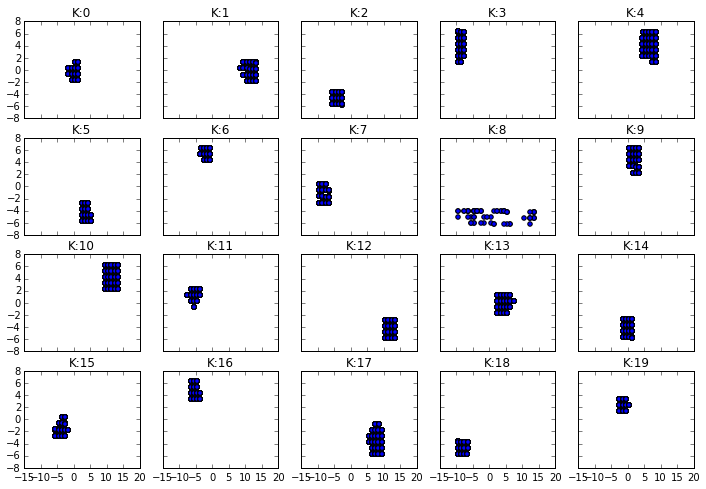

In [153]:
def plot_clusters():
    f, axarr = plt.subplots(4, 5, sharex=True, sharey=True)
    le = MultiColumnLabelEncoder()
    tr = train_raw[['X','Y','TimeOfDay','Year']].copy()
    tr = le.fit_transform(tr)
    pca = PCA(n_components=2)
    X = pca.fit_transform(tr)
    K = np.array(train_raw['KMcluster'])
    for i in range(20):
        if i<5: e=0
        elif i<10: e=1
        elif i<15: e=2
        else: e=3
        z = i - 5*e
        axarr[e, z].scatter(X[K==i,0]\
                            ,X[K==i,1]\
                            )
        axarr[e, z].set_title('K:{}'.format(i))
        plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
        plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plot_clusters()

Accuracy: 23.83%
Predicted    1     2    3   4     5    6     7     8     9    10    All
True                                                                   
1          123    92   73   4   124   38   127   199   134   104   1018
2           29   297   64   6    84    8    77   190   144   117   1016
3           39   100  100   4    82   20   100   135   127    73    780
4            6    37   10   9    22    2    14    48    83    46    277
5           60   140   67   6   226   35   150   246   179    92   1201
6           55    70   30   0    59   41   118   145    88    77    683
7           49   116   49   3   103   24   297   300   194   135   1270
8           44   131   57   1   124   24   148   535   193   125   1382
9           27   121   61   5    95    9    80   198   555    76   1227
10          58   110   53   2   106   24   147   274   172   200   1146
All        490  1214  564  40  1025  225  1258  2270  1869  1045  10000


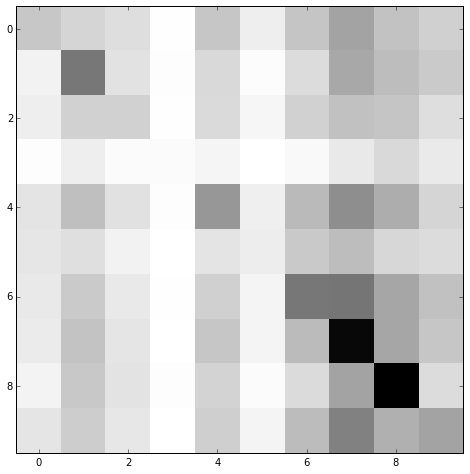

In [213]:
def predict_metaclass():
    '''Predict the metaclass of crime
       Use the outputted algorithm to 
       predict metaclass in the training data
    '''
    tr = sample_df(train_raw,'Category',set(train_raw['Category']),\
                                      group_n=200000)
    
    new_fields = [
        'PdDistrict','DaySegment','DayOfWeek',\
        'DayOfMonth','Year','KMcluster','KMdistance'
    ]
    cat_fields = [
        'PdDistrict','DayOfWeek','DaySegment','TimeOfDay',\
        'DayOfMonth','Year','KMcluster','collar_id'
    ]
    dev_train, dev_train_labels = tr[new_fields][10001:],\
                           tr['collar_id'][10001:]
    dev_test, dev_test_labels = tr[new_fields][:10000],\
                            tr['collar_id'][:10000]
    
    # Create pipeline
    le = MultiColumnLabelEncoder()
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    #md = MultinomialNB(alpha=0.01)
    md = LogisticRegression(C=1,solver='lbfgs',multi_class='multinomial')
    pl = Pipeline([('le',le),('ohe',ohe),('md',md)])
    
    '''
    param_grid = dict(md__C=[0.1,1,1000])
    gs = GridSearchCV(pl, param_grid=param_grid, verbose=10)
    gs.fit(dev_train, dev_train_labels)
    print gs.best_estimator_ 
    '''
    
    # Fit training data 
    pl.fit(dev_train, dev_train_labels)
    
    # Show results
    print 'Accuracy: {}%'.format(round(pl.score(dev_test, \
                                                 dev_test_labels),4)*100)
    predictions = pl.predict(dev_test)
    conf = confusion_matrix(dev_test_labels,predictions)
    plt.imshow(conf, cmap='binary',interpolation='nearest')
    print pd.crosstab(dev_test_labels, predictions, \
                      rownames=['True'], colnames=['Predicted'], \
                      margins=True)
    
    # Return model for later use
    return pl  

pl_metaclass = predict_metaclass()

In [214]:
new_fields = [
        'PdDistrict','DaySegment','DayOfWeek',\
        'DayOfMonth','Year','KMcluster','KMdistance'
    ]
le,ohe,md = [ x[1] for x in pl_metaclass.steps[:3] ]
tr = le.transform(train_raw[new_fields])
tr = ohe.transform(tr)
train_raw['prediction_score'] = \
    np.max(md.decision_function(tr),axis=1)

tr = le.transform(test_raw[new_fields])
tr = ohe.transform(tr)
test_raw['prediction_score'] = \
    np.max(md.decision_function(tr),axis=1)

### Get data from other sources

SF OpenData has a ton of supplemental data sources that will be great to try out for this effort.  

NOTE: one of them is actually a list of crimes that seems to match data in the training set. I will NOT use that data to train my model or match against the test dataset; however, I believe that many contestants are doing this, given that there is a very clear separation in scores that indicates to me that maybe there is some cheating happening.

In [4]:
# http://spatialreference.org/ref/epsg/2227/
p = Proj('+proj=lcc +init=EPSG:2227 +datum=NAD83 +units=us-ft +no_defs',preserve_units=True)
convert_vals = np.vectorize(lambda x,y: p(x,y))
convert_vals_inv = np.vectorize(lambda x,y: p(x,y,inverse=True))

In [5]:
shpfilename_elect = 'Data/SanFranciscoElectricityUse/SanFranciscoElectricityUse.shp'
shpfilename_school = 'Data/schools_public_pt/schools_public_pt.shp'
shpfilename_zoning = 'Data/Zoning/Zoning_Districts.shp'
shpfilename_neighborhoods = 'Data/planning_neighborhoods/planning_neighborhoods.shp'
street_tree_locations = 'Data/Street_Tree_List.csv'
report311_locations = 'Data/All_cases_map_view.csv'
business_locations = 'Data/Registered_Business_Map.csv'
park_locations = 'Data/Park_and_Open_Space_Map.csv'
offstreet_parking_locations = 'Data/Off-street_parking_lots_and_parking_garages_map.csv'
private_garage_locations = 'Data/PrivateGarages_Lots.csv'

In [6]:
# Convert lat/lon to coordinates that match shp
train_raw['New_X'], train_raw['New_Y'] = \
    convert_vals(train_raw['X'],train_raw['Y'])

test_raw['New_X'], test_raw['New_Y'] = \
    convert_vals(test_raw['X'],test_raw['Y'])

#### Read CSVs

In [7]:
trees = pd.read_csv(street_tree_locations)
report311 = pd.read_csv(report311_locations)
businesses = pd.read_csv(business_locations)
parks = pd.read_csv(park_locations)
offstreet_parking = pd.read_csv(offstreet_parking_locations)
private_garages = pd.read_csv(private_garage_locations)

/Library/Python/2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [8]:
def run_iters_points(points, point_locator, \
              proximity=100,log_at=100000):
    ''' Iterate through points and return distance
        to the nearest point
    '''
    point_fun = lambda x,pl: pl.proximity(x,proximity)
    surrounding_pts = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: print 'running {0} row'.format(i)
        pts = point_fun(p,point_locator)
        surrounding_pts[i] = len(pts)
    return surrounding_pts

In [9]:
base_points = [ Point((x,y)) for x,y in zip(train_raw['New_X'],train_raw['New_Y']) ]
tree_points = [ Point((x,y)) for x,y in zip(trees['XCoord'],trees['YCoord']) ]

In [ ]:
def worker(points):
    return pd.DataFrame({'trees':run_iters_points(points\
                                  ,BruteForcePointLocator(tree_points)\
                                  ,proximity=100
                                  ,log_at=10000)})

pool = multiprocessing.Pool()

# get list of pieces
points_list = [base_points[:110000]\
            ,base_points[110001:200001]\
            ,base_points[200001:280000]\
            ,base_points[280001:390000]\
            ,base_points[390001:490000]\
            ,base_points[490001:570000]\
            ,base_points[570001:650000]\
            ,base_points[650001:780000]\
            ,base_points[780001:]]

res = pool.map(worker, points_list)
pool.close()
pool.join()

train_raw['trees_surrounding'] = pd.concat(res)
train_raw['trees_surrounding'].to_csv('Data/trees_surrounding')

#### Process shapefiles

In [218]:
def make_points(x):
    ''' Create list of Points objects
    '''
    out = []
    n = x.shape[0]
    for i in range(n):
        out.append(Point((x['New_X'][i],x['New_Y'][i])))
    return out
points = make_points(train_raw[['New_X','New_Y']])
test_points = make_points(test_raw[['New_X','New_Y']])

##### Polygon search functions

In [219]:
def return_poly_id(pl,x):
        ''' Find the polygon within the 
            PolygonLocator that 
            matches to each point
        '''
        try:
            return pl.contains_point(x)[0].id
        except IndexError:
            return -1

def polygon_search(shpfilename,run_iters,\
                   pts,test=False,\
                   return_poly_id=return_poly_id):
    ''' Iterate through shapefile polygons
        and find id of polgy for each datapoint
        
        Need to create these functions:
            1)a polygon match function
                (above)
            2)a run_iters function that 
                accepts a PolygonLocator object,
                a polygon match function (above),
                and a list of points to iterate over.         
    '''
    shp = pysal.open(shpfilename,'r')
    pl = PolygonLocator([p for p in shp])
    shp.close()
    run_iters(pl,return_poly_id,pts,test)


##### Coordinate search functions (faster)

In [ ]:
def coord_search(points, \
                 pl, \
                 run_iters_fun, \
                 locator_fun=BruteForcePointLocator):
    ''' Since polygon search is not very efficient
        when there are many polygons, instead
        do a comparison to each polygon centroid 
    '''
    gather_centroids = lambda shp: [p.centroid for p in shp]

    # Read file
    shp = pysal.open(shpfile,'r')
    centroids = gather_centroids(shp)
    pl = locator_fun(centroids)
    shp.close()
    
    # Return the nearest points
    nearest_ids = run_iters_fun(points,pl,centroids)
    
    return nearest_ids

In [236]:
def coord_search_centroid(shpfile, points, \
                 run_iters_fun, \
                 locator_fun=BruteForcePointLocator):
    ''' Since polygon search is not very efficient
        when there are many polygons, instead
        do a comparison to each polygon centroid 
    '''
    gather_centroids = lambda shp: [p.centroid for p in shp]

    # Read file
    shp = pysal.open(shpfile,'r')
    centroids = gather_centroids(shp)
    pl = locator_fun(centroids)
    shp.close()
    
    # Return the nearest points
    nearest_ids = run_iters_fun(points,pl,centroids)
    
    return nearest_ids

##### Read shapefiles

In [237]:
def read_schoolfile():
    ''' Process school file into pandas dataframe '''
    shp = fiona.open(shpfilename_school)
    n = len(shp)
    SCHOOL_TYP,\
    DEPT,\
    FACILITY_N,\
    DEPTNAME,\
    FACILITY_I = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        SCHOOL_TYP[i] = s['properties']['SCHOOL_TYP']
        DEPT [i] = s['properties']['DEPT']
        FACILITY_N [i] = s['properties']['FACILITY_N']
        DEPTNAME [i] = s['properties']['DEPTNAME']
        FACILITY_I [i] = s['properties']['FACILITY_I']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'SCHOOL_TYP':SCHOOL_TYP
        })
    return props_df

props_df = read_schoolfile()

In [230]:
def read_zonefile():
    ''' Process zones file into pandas dataframe '''
    shp = fiona.open(shpfilename_zoning)
    n = len(shp)
    ZONING_SIM,\
    DISTRICTNA = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        ZONING_SIM[i] = s['properties']['ZONING_SIM']
        DISTRICTNA[i] = s['properties']['DISTRICTNA']
    shp.close()

    props_df_zoning = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'ZONING_SIM':ZONING_SIM,
            'DISTRICTNA':DISTRICTNA
        })

props_df_zoning = read_zonefile()

In [228]:
def read_electfile():
    shp = fiona.open(shpfilename_elect)
    n = len(shp)
    kWh_pC,\
    kWh,\
    Zip,\
    Pop2010_zc = \
        np.empty(n,dtype=np.float64),\
        np.empty(n,dtype=np.float64),\
        np.empty(n,dtype='|S10'),\
        np.empty(n,dtype=np.int64)
    for i,s in enumerate(shp):
        kWh_pC[i] = s['properties']['kWh_pC']
        kWh [i] = s['properties']['kWh']
        Zip [i] = s['properties']['Zip']
        Pop2010_zc [i] = s['properties']['Pop2010_zc']
    shp.close()

    props_df_elect = pd.DataFrame({
            'Id':[i+1 for i in range(n)],\
            'kWh_pC':kWh_pC,\
            'kWh':kWh,\
            'Zip':Zip,\
            'Pop2010_zc':Pop2010_zc\
        })

props_df_elect = read_electfile()

In [246]:
def read_neighborhoods():
    ''' Process school file into pandas dataframe '''
    shp = fiona.open(shpfilename_neighborhoods)
    n = len(shp)
    NEIGHBORHOOD = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        NEIGHBORHOOD[i] = s['properties']['neighborho']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'NEIGHBORHOOD':NEIGHBORHOOD
        })
    return props_df

neighborhoods_df = read_neighborhoods()

In [255]:
def read_sdists():
    ''' Process supervistoral district file into pandas dataframe '''
    shp = fiona.open(shpfilename_sv_districts)
    n = len(shp)
    supname = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        supname[i] = s['properties']['supname']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'supname':supname
        })
    return props_df

sdist_df = read_sdists()

In [223]:
def coord_search_schools(pts):
    ''' Find nearest point and measure distance
        for every datapoint 
    '''
    hs = props_df[props_df['SCHOOL_TYP']=='High School']['Id']
    cs = props_df[props_df['SCHOOL_TYP']=='County School']['Id']
    chs = props_df[props_df['SCHOOL_TYP']=='Charter School']['Id']
    ms = props_df[props_df['SCHOOL_TYP']=='Middle School']['Id']
    
    shp = pysal.open(shpfilename_school,'r')
    pl_hs = BruteForcePointLocator([p for p in shp if p.id in hs])
    pl_cs = BruteForcePointLocator([p for p in shp if p.id in cs])
    pl_chs = BruteForcePointLocator([p for p in shp if p.id in chs])
    pl_ms = BruteForcePointLocator([p for p in shp if p.id in ms])
    shp.close()

    return_point_hs = lambda x: pl_hs.nearest(x)
    return_point_cs = lambda x: pl_cs.nearest(x)
    return_point_chs = lambda x: pl_chs.nearest(x)
    return_point_ms = lambda x: pl_ms.nearest(x)
    
    # point_ids = np.zeros(len(points),dtype=np.int8)
    point_distances_hs = np.zeros(len(pts),dtype=np.float64)
    point_distances_cs = np.zeros(len(pts),dtype=np.float64)
    point_distances_chs = np.zeros(len(pts),dtype=np.float64)
    point_distances_ms = np.zeros(len(pts),dtype=np.float64)
    
    def run_iters():
        for i,p in enumerate(points):
            if i%100000==0: print 'running {0} row'.format(i)
            pt_hs = return_point_hs(p)
            pt_cs = return_point_cs(p)
            pt_chs = return_point_chs(p)
            pt_ms = return_point_ms(p)
            
            point_distances_hs[i] = arcdist(p,pt_hs)
            point_distances_cs[i] = arcdist(p,pt_cs)
            point_distances_chs[i] = arcdist(p,pt_chs)
            point_distances_ms[i] = arcdist(p,pt_ms)

    run_iters()
    
    return point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms

'''            
point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms = coord_search_schools(points)
test_point_distances_hs,\
            test_point_distances_cs,\
            test_point_distances_chs,\
            test_point_distances_ms = coord_search_schools(test_points)
'''

In [ ]:
def run_iters_elect(plocator,return_poly_id,pts,test):
    poly_ids = np.zeros(len(pts),dtype=np.int8)
    for i,p in enumerate(pts):
        if i%100000==0: print 'running {0} row'.format(i)
        poly_ids[i] = return_poly_id(plocator,p)
    # Save data because this step takes >5hrs to finish
    if test: outname = 'Data/test_poly_ids2.csv'
    else: outname = 'Data/poly_ids2.csv'
    poly_ids_df = pd.DataFrame({'elect_poly_id':poly_ids})
    poly_ids_df.to_csv(outname,index=False)

#polygon_search(shpfilename_elect,run_iters_elect,points,test=False)
#polygon_search(shpfilename_elect,run_iters_elect,test_points,test=True)

In [ ]:
def run_iters_zoning(plocator,return_poly_id,pts,test):
    poly_ids = np.zeros(len(pts),dtype=np.int8)
    for i,p in enumerate(pts):
        if i%1==100000: print 'running {0} row'.format(i)
        poly_ids[i] = return_poly_id(plocator,p)
    # Save data because this step takes >5hrs to finish
    if test: outname = 'Data/test_zoning_ids.csv'
    else: outname = 'Data/zoning_ids.csv'
    poly_ids_df = pd.DataFrame({'zoning_id':poly_ids})
    poly_ids_df.to_csv(outname,index=False)

#polygon_search(shpfilename_zoning,run_iters_zoning,points,test=False)
#polygon_search(shpfilename_zoning,run_iters_zoning,test_points,test=True)

In [ ]:
def run_iters_centroid(points, point_locator, centroids, \
              log_at=100000):
    ''' Iterate through points to find 
        the nearest matched point
    '''
    point_fun = lambda x,pl: pl.nearest(x)
    id_fun = lambda p, centroids: [i for i,c in enumerate(centroids)\
                                  if c==p][0]
    nearest_ids = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: print 'running {0} row'.format(i)
        pt = point_fun(p,point_locator)
        pt_id = id_fun(pt, centroids)
        nearest_ids[i] = pt_id
    return nearest_ids

In [ ]:
def save_file(array_to_save, colname, filename):
    ''' Write column to CSV '''
    array_to_save_df = pd.DataFrame({colname:array_to_save})
    array_to_save_df.to_csv(filename,index=False)

'''
zone_ids = coord_search_centroid(shpfilename_zoning,points,\
                        run_iters_centroid)
save_file(zone_ids, 'zoning_id', 'Data/zoning_ids2.csv')

test_zone_ids = coord_search_centroid(shpfilename_zoning,test_points,\
                         run_iters_centroid)
save_file(test_zone_ids, 'zoning_id', 'Data/test_zoning_ids2.csv')
'''

In [ ]:
# only run this after zone ids are compiled
zone_ids = pd.read_csv('Data/zoning_ids.csv')
test_zone_ids = pd.read_csv('Data/test_zoning_ids.csv')
all_zones = pd.merge(zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])
test_all_zones = pd.merge(test_zone_ids,props_df_zoning,'left',\
                    left_on=['zoning_id'], right_on=['Id'])

In [ ]:
# only run this after ids are compiled
poly_ids_df_elect = pd.read_csv('Data/poly_ids.csv')
test_poly_ids_df_elect = pd.read_csv('Data/test_poly_ids.csv')
all_elects = pd.merge(poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])
test_elects = pd.merge(test_poly_ids_df_elect, props_df_elect, 'left',\
                     left_on=['elect_poly_id'], right_on=['Id'])

##### Add new columns

In [ ]:
elect_cols = ['kWh_pC','kWh','Zip','Pop2010_zc']
train_raw[elect_cols] = all_elects[elect_cols] 
test_raw[elect_cols] = test_elects[elect_cols] 

In [ ]:
# School features had little/no effect on the model
# school_nearby = np.vectorize(lambda x: True if x<=1000 else False)
# train_raw['HS_DISTANCE'] = point_distances_hs.astype(np.float64)
# train_raw['CS_DISTANCE'] = point_distances_cs.astype(np.float64)
# train_raw['CHS_DISTANCE'] = point_distances_chs.astype(np.float64)
# train_raw['MS_DISTANCE'] = point_distances_ms.astype(np.float64)
# train_raw['HS_NEARBY'] = school_nearby(train_raw['HS_DISTANCE'])
# train_raw['CS_NEARBY'] = school_nearby(train_raw['CS_DISTANCE'])
# train_raw['CHS_NEARBY'] = school_nearby(train_raw['CHS_DISTANCE'])
# train_raw['MS_NEARBY'] = school_nearby(train_raw['MS_DISTANCE'])

# test_raw['HS_DISTANCE'] = test_point_distances_hs.astype(np.float64)
# test_raw['CS_DISTANCE'] = test_point_distances_cs.astype(np.float64)
# test_raw['CHS_DISTANCE'] = test_point_distances_chs.astype(np.float64)
# test_raw['MS_DISTANCE'] = test_point_distances_ms.astype(np.float64)
# test_raw['HS_NEARBY'] = school_nearby(test_raw['HS_DISTANCE'])
# test_raw['CS_NEARBY'] = school_nearby(test_raw['CS_DISTANCE'])
# test_raw['CHS_NEARBY'] = school_nearby(test_raw['CHS_DISTANCE'])
# test_raw['MS_NEARBY'] = school_nearby(test_raw['MS_DISTANCE'])

In [ ]:
train_raw['ZONING_SIM'] = all_zones['ZONING_SIM']
train_raw['DISTRICT_NAME'] = all_zones['DISTRICTNA']
train_raw['ZONE_ID'] = all_zones['Id']

test_raw['ZONING_SIM'] = test_all_zones['ZONING_SIM']
test_raw['DISTRICT_NAME'] = test_all_zones['DISTRICTNA']
test_raw['ZONE_ID'] = test_all_zones['Id']

##### Test performance

In [ ]:
new_fields = [
    'PdDistrict','DaySegment',\
    'kWh','Zip','Pop2010_zc','Year','KMcluster'
]
cat_fields = [
    'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
    'Zip','KMcluster',\
    'ZONING_SIM','DISTRICT_NAME','ZONE_ID'
]
train_raw = train_raw.iloc[\
                    np.random.permutation(len(train_raw))]
dev_train, dev_train_labels = train_raw[new_fields][10001:],\
                        train_raw['Category'][10001:]
dev_train_weights = np.array(train_raw['sample_weight'][10001:])
dev_test, dev_test_labels = train_raw[new_fields][:10000],\
                        train_raw['Category'][:10000]

In [ ]:
def add_knnguess():
    knn = KNeighborsClassifier(n_neighbors=20)
    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=False)
    pca = PCA(n_components = 20)

    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('knn', knn)])
    pl.fit(dev_train, dev_train_labels)
    train_raw['KNNguess'] = pl.predict(train_raw[new_fields])
    test_raw['KNNguess'] = pl.predict(test_raw[new_fields])

add_knnguess()

In [ ]:
def runmodel(n=100):
    new_fields = [
        'PdDistrict','DaySegment',\
        'kWh','Zip','Pop2010_zc','Year','KMcluster'
    ]
    cat_fields = [
        'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
        'Zip','KMcluster',\
        'ZONING_SIM','DISTRICT_NAME','ZONE_ID','KNNguess'
    ]

    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=False)
    rf = RandomForestClassifier(n_jobs=2, n_estimators=n) 
    pca = PCA(n_components = 20)

    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('rf', rf)])
    pl.fit(dev_train, dev_train_labels,rf__sample_weight=dev_train_weights)
    print 'Accuracy: {0}%'.format(round(pl.score(dev_test, dev_test_labels),4)*100)
    return pl 

# pl = runmodel(300)

In [ ]:
def show_pca():
    exp_var = np.cumsum(pl.named_steps['pca'].explained_variance_ratio_)
    n = len(exp_var)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('PCA explained variance')
    ax.set_xlabel('Feature number')
    ax.set_ylabel('Explained Variance')
    ax.plot(range(n),exp_var,'-', linewidth=2)

    plt.show()

# show_pca()

##### Make another submission

In [ ]:
def save_testdata():
    test_raw.to_csv('Data/test_raw_nf.csv',index=False)

# save_testdata()

In [ ]:
# predictions = pl.predict(test_raw[new_fields])

In [ ]:
def write_to_submissionfile():
    l = len(test_raw)
    submission = np.zeros((l,40),dtype=np.int32)
    submission[:,0] = range(l)
    cols = sorted(set(train_raw['Category']))
    for i,c in enumerate(cols):
        submission[:,i+1] = predictions == c

    submission_cols = ['Id']
    submission_cols.extend(cols)
    submission_df = pd.DataFrame(submission,columns=submission_cols)
    submission_df.head()

    submission_df.to_csv('Data/submission_file2.csv',index=False)
    
# write_to_submissionfile()

#### Part 3 - Error Diagnosis

In [ ]:
predictions = pl.predict(dev_test)
conf = confusion_matrix(dev_test_labels,predictions)
plt.imshow(conf, cmap='binary')
pd.crosstab(dev_test_labels, predictions, rownames=['True'], colnames=['Predicted'], margins=True)